In [ ]:
import torch
import torch.nn as nn
import torchvision.ops
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F
from torchsummary import summary
import time
import matplotlib.pyplot as plt


In [ ]:
# Set device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

100%|██████████| 170498071/170498071 [00:10<00:00, 15626410.59it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# Define CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv3(x))
        x = nn.functional.max_pool2d(x, 2)
        x = x.view(-1, 256 * 4 * 4)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
class DeformableConv2d(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size=3,
                 stride=1,
                 padding=1,
                 dilation=1,
                 bias=False):
        super(DeformableConv2d, self).__init__()

        assert type(kernel_size) == tuple or type(kernel_size) == int

        kernel_size = kernel_size if type(kernel_size) == tuple else (kernel_size, kernel_size)
        self.stride = stride if type(stride) == tuple else (stride, stride)
        self.padding = padding
        self.dilation = dilation

        self.offset_conv = nn.Conv2d(in_channels,
                                     2 * kernel_size[0] * kernel_size[1],
                                     kernel_size=kernel_size,
                                     stride=stride,
                                     padding=self.padding,
                                     dilation=self.dilation,
                                     bias=True)

        nn.init.constant_(self.offset_conv.weight, 0.)
        nn.init.constant_(self.offset_conv.bias, 0.)

        self.modulator_conv = nn.Conv2d(in_channels,
                                        1 * kernel_size[0] * kernel_size[1],
                                        kernel_size=kernel_size,
                                        stride=stride,
                                        padding=self.padding,
                                        dilation=self.dilation,
                                        bias=True)

        nn.init.constant_(self.modulator_conv.weight, 0.)
        nn.init.constant_(self.modulator_conv.bias, 0.)

        self.regular_conv = nn.Conv2d(in_channels=in_channels,
                                      out_channels=out_channels,
                                      kernel_size=kernel_size,
                                      stride=stride,
                                      padding=self.padding,
                                      dilation=self.dilation,
                                      bias=bias)

    def forward(self, x):

        offset = self.offset_conv(x)
        modulator = 2. * torch.sigmoid(self.modulator_conv(x))
        x = torchvision.ops.deform_conv2d(input=x,
                                          offset=offset,
                                          weight=self.regular_conv.weight,
                                          bias=self.regular_conv.bias,
                                          padding=self.padding,
                                          mask=modulator,
                                          stride=self.stride,
                                          dilation=self.dilation)
        return x

In [ ]:
class DCNModel(nn.Module):
    def __init__(self):
        super(DCNModel, self).__init__()
        self.conv1 = DeformableConv2d(3, 64, kernel_size=3)
        self.conv2 = DeformableConv2d(64, 128, kernel_size=3)
        self.conv3 = DeformableConv2d(128, 256, kernel_size=3)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv3(x))
        x = nn.functional.max_pool2d(x, 2)
        x = x.view(-1, 256 * 4 * 4)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# Function to train a model
def train_model(model, criterion, optimizer, num_epochs=10):
    start_time = time.time()
    train_losses = []
    train_acc = []
    test_losses = []
    test_acc = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = outputs.max(1)
            total_train += labels.size(0)
            correct_train += predicted.eq(labels).sum().item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_accuracy = 100 * correct_train / total_train
        train_acc.append(train_accuracy)
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, "
              f"Train Accuracy: {train_accuracy:.2f}")

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Training complete in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s")

    start_time = time.time()
    model.eval()
    test_correct = 0
    test_total = 0
    test_loss = 0
    with torch.no_grad():
      for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

    test_acc = test_correct / test_total
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test Loss: {test_loss/len(test_loader):.4f}")


    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Testing complete in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s")

    return train_losses, test_loss, train_acc, test_acc

# CNN model

In [ ]:
# Train CNN model
cnn_model = CNNModel().to(device)
cnn_criterion = nn.CrossEntropyLoss()
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

cnn_train_losses, cnn_test_losses, cnn_train_acc, cnn_test_acc = train_model(cnn_model, cnn_criterion, cnn_optimizer)

Epoch 1/10, Train Loss: 1.2958, Train Accuracy: 53.23
Epoch 2/10, Train Loss: 0.8232, Train Accuracy: 70.98
Epoch 3/10, Train Loss: 0.6248, Train Accuracy: 78.10
Epoch 4/10, Train Loss: 0.4739, Train Accuracy: 83.47
Epoch 5/10, Train Loss: 0.3441, Train Accuracy: 87.88
Epoch 6/10, Train Loss: 0.2282, Train Accuracy: 91.94
Epoch 7/10, Train Loss: 0.1557, Train Accuracy: 94.53
Epoch 8/10, Train Loss: 0.1162, Train Accuracy: 95.87
Epoch 9/10, Train Loss: 0.1057, Train Accuracy: 96.35
Epoch 10/10, Train Loss: 0.0829, Train Accuracy: 97.21
Training complete in 2m 39s
Test Accuracy: 0.7605
Test Loss: 1.2667
Testing complete in 0m 3s


# DCN model

In [ ]:
# Train DCN model
dcn_model = DCNModel().to(device)
dcn_criterion = nn.CrossEntropyLoss()
dcn_optimizer = optim.Adam(dcn_model.parameters(), lr=0.001)

dcn_train_losses, dcn_test_losses, dcn_train_acc, dcn_test_acc = train_model(dcn_model, dcn_criterion, dcn_optimizer)

Epoch 1/10, Train Loss: 1.3064, Train Accuracy: 52.20
Epoch 2/10, Train Loss: 0.8507, Train Accuracy: 69.75
Epoch 3/10, Train Loss: 0.6730, Train Accuracy: 76.20
Epoch 4/10, Train Loss: 0.5500, Train Accuracy: 80.52
Epoch 5/10, Train Loss: 0.4479, Train Accuracy: 84.09
Epoch 6/10, Train Loss: 0.3528, Train Accuracy: 87.45
Epoch 7/10, Train Loss: 0.2738, Train Accuracy: 90.34
Epoch 8/10, Train Loss: 0.2086, Train Accuracy: 92.67
Epoch 9/10, Train Loss: 0.1552, Train Accuracy: 94.55
Epoch 10/10, Train Loss: 0.1306, Train Accuracy: 95.43
Training complete in 3m 27s
Test Accuracy: 0.7706
Test Loss: 0.9690
Testing complete in 0m 4s


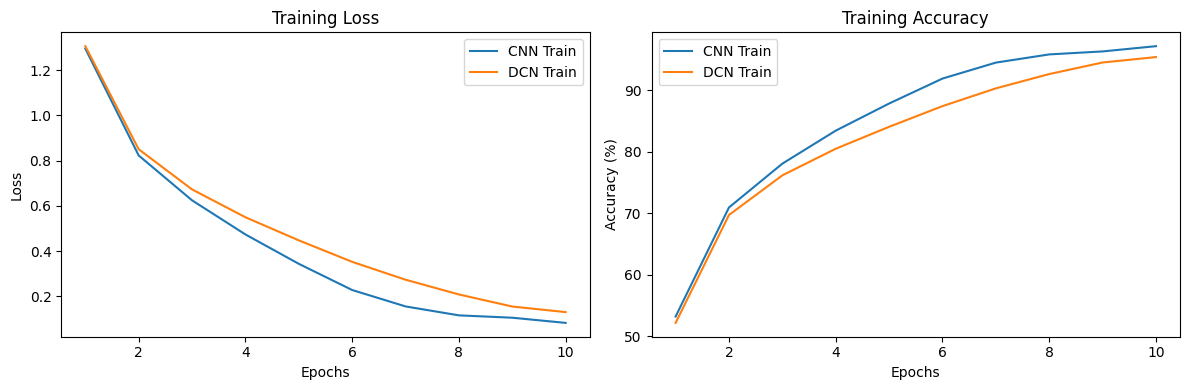

In [ ]:
# Plotting the results
epochs = range(1, len(cnn_train_losses) + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, cnn_train_losses, label='CNN Train')
plt.plot(epochs, dcn_train_losses, label='DCN Train')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, cnn_train_acc, label='CNN Train')
plt.plot(epochs, dcn_train_acc, label='DCN Train')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()
